In [19]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error

import pickle

In [31]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/workspaces/mlops_zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1724158690277, experiment_id='1', last_update_time=1724158690277, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [43]:
model_dict = {
        'linear': LinearRegression(),
        'lasso': Lasso(),
        'ridge': Ridge()
    }

def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda dt: dt.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration < 60) & (df.trip_distance < 25)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

def vectorizer(categorical, numerical, df_train, df_val):
    dv = DictVectorizer()

    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return X_train, X_val

def model(categorical, numerical, df_train, df_val, target, model_selected):
    X_train, X_val = vectorizer(categorical, numerical, df_train, df_val)
    model = model_dict[model_selected]
    
    y_train = df_train[target].values
    y_val = df_val[target].values
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    return root_mean_squared_error(y_val, y_pred), model, y_pred, y_val

def save_model(path, model_name, dv, model):
    with open(f'{path}/{model_name}.bin', 'wb') as f_out:
        pickle.dump((dv, model), f_out)    

In [33]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [34]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [7]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df['duration'] = df['duration'].apply(lambda dt: dt.total_seconds() / 60)
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


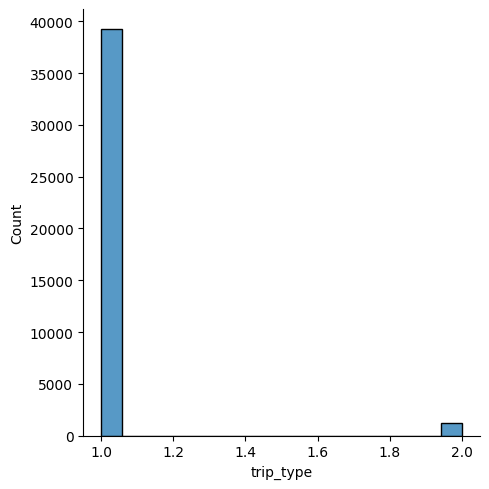

In [8]:
sns.displot(df.trip_type)

In [13]:
df[df.trip_type == 2].describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.0,1238.000000,1238.000000
mean,1.938611,4.948304,127.220517,152.746365,1.264943,2.159968,21.256680,0.001212,0.008078,1.060646,0.104491,0.274798,22.830299,1.418417,2.0,0.124394,18.305493
std,0.240140,0.451971,77.287748,85.334912,0.768782,4.257244,31.238374,0.031765,0.063061,2.757900,1.006129,0.094701,32.057506,0.560964,0.0,0.571729,108.364382
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-280.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,-280.300000,1.000000,2.0,0.000000,0.000000
25%,2.000000,5.000000,69.000000,74.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.300000,10.300000,1.000000,2.0,0.000000,0.100000
50%,2.000000,5.000000,97.500000,152.000000,1.000000,0.205000,14.000000,0.000000,0.000000,0.000000,0.000000,0.300000,15.300000,1.000000,2.0,0.000000,1.666667
75%,2.000000,5.000000,195.000000,243.000000,1.000000,2.797500,20.000000,0.000000,0.000000,1.000000,0.000000,0.300000,23.050000,2.000000,2.0,0.000000,14.216667
max,2.000000,5.000000,265.000000,265.000000,8.000000,64.700000,284.000000,1.000000,0.500000,38.000000,17.870000,0.300000,284.300000,4.000000,2.0,2.750000,1416.100000


In [6]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [14]:
df.trip_distance.describe(percentiles=[0.98, 0.99])

count     76518.000000
mean         40.862552
std        1924.408778
min           0.000000
50%           2.590000
98%          20.756600
99%          24.273200
max      244152.010000
Name: trip_distance, dtype: float64

In [11]:
df.duration.describe(percentiles=[0.97, 0.98])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
97%         50.191500
98%         56.000000
max       1439.600000
Name: duration, dtype: float64

In [15]:
df[(df.duration < 60) & (df.trip_distance < 25)].describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
count,74853.000000,39387.000000,74853.000000,74853.000000,39387.000000,74853.000000,74853.000000,74853.000000,74853.000000,74853.000000,74853.000000,74853.000000,74853.000000,39387.000000,39387.000000,39387.000000,74853.000000
mean,1.903491,1.143017,109.361509,130.789374,1.192399,4.234069,19.065304,0.743966,0.252769,1.500919,0.475762,0.298132,22.629683,1.413994,1.030695,0.624578,16.345211
std,0.295290,0.882346,70.988775,77.109565,0.760712,4.508827,13.254877,1.187017,0.251518,1.841435,1.704704,0.029405,14.515654,0.518862,0.172493,1.152148,11.435629
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-280.000000,-5.500000,-0.500000,-9.450000,0.000000,-0.300000,-280.300000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,52.000000,65.000000,1.000000,1.290000,9.000000,0.000000,0.000000,0.000000,0.000000,0.300000,11.760000,1.000000,1.000000,0.000000,8.000000
50%,2.000000,1.000000,76.000000,129.000000,1.000000,2.510000,16.730000,0.000000,0.500000,1.160000,0.000000,0.300000,20.050000,1.000000,1.000000,0.000000,13.383333
75%,2.000000,1.000000,166.000000,197.000000,1.000000,5.480000,24.810000,1.000000,0.500000,2.750000,0.000000,0.300000,28.840000,2.000000,1.000000,0.000000,22.000000
max,2.000000,99.000000,265.000000,265.000000,8.000000,24.980000,284.000000,8.250000,0.500000,110.000000,31.250000,0.300000,284.300000,5.000000,2.000000,2.750000,59.983333


In [24]:
df = df[(df.duration >= 1) & (df.duration < 60) & (df.trip_distance < 25)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [28]:
df.duration.mean()

16.66195036668713

In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [12]:
df[categorical] = df[categorical].astype(str)

In [34]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [13]:
df[categorical + numerical]

,PULocationID,DOLocationID,trip_distance
0,43,151,1.01
1,166,239,2.53
2,41,42,1.12
3,168,75,1.99
4,265,265,0.00
...,...,...,...
76513,81,90,17.63
76514,35,213,18.36
76515,74,69,2.50
76516,168,215,14.48


In [14]:
train_dict = df[categorical + numerical].to_dict(orient='records')

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [39]:
X_train

<73405x504 sparse matrix of type '<class 'numpy.float64'>'
	with 220215 stored elements in Compressed Sparse Row format>

In [41]:
target = 'duration'
y = df[target].values
y

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [ ]:
#########   Clean Code   #############

In [35]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [36]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

mse_linear, lr, y_pred_lr, y_val_linear = model(categorical, numerical, df_train, df_val, target, model_selected='linear')
mse_lasso, lasso, y_pred_lasso, y_val_lasso = model(categorical, numerical, df_train, df_val, target, model_selected='lasso')
mse_ridge, ridge, y_pred_ridge, y_val_ridge = model(categorical, numerical, df_train, df_val, target, model_selected='ridge')

print(f"Mean Squared Error => Linear: {mse_linear}  Lasso: {mse_lasso}  Ridge: {mse_ridge}")

Mean Squared Error => Linear: 7.169186639853783  Lasso: 7.6421758358044345  Ridge: 7.1652212778507405


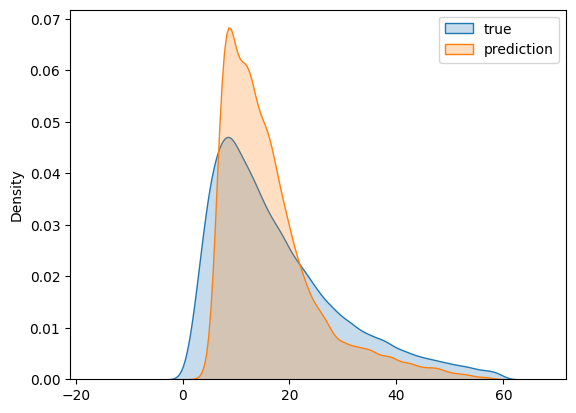

In [40]:
sns.kdeplot(y_val_ridge, label='true', fill=True)
sns.kdeplot(y_pred_ridge, label='prediction', fill=True)

plt.legend()

plt.show()

In [ ]:
###### Modify features #########

In [25]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [26]:
df_train['PU_DO'] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val['PU_DO'] = df_val.PULocationID + '_' + df_val.DOLocationID

In [27]:
categorical = ['PU_DO']
numerical = ['trip_distance']
target = 'duration'

mse_linear, lr, y_pred_lr, y_val_linear = model(categorical, numerical, df_train, df_val, target, model_selected='linear')
mse_lasso, lasso, y_pred_lasso, y_val_lasso = model(categorical, numerical, df_train, df_val, target, model_selected='lasso')
mse_ridge, ridge, y_pred_ridge, y_val_ridge = model(categorical, numerical, df_train, df_val, target, model_selected='ridge')

print(f"Mean Squared Error => Linear: {mse_linear}  Lasso: {mse_lasso}  Ridge: {mse_ridge}")

Mean Squared Error => Linear: 6.6631507671804355  Lasso: 7.6421758358044345  Ridge: 6.528045991917764


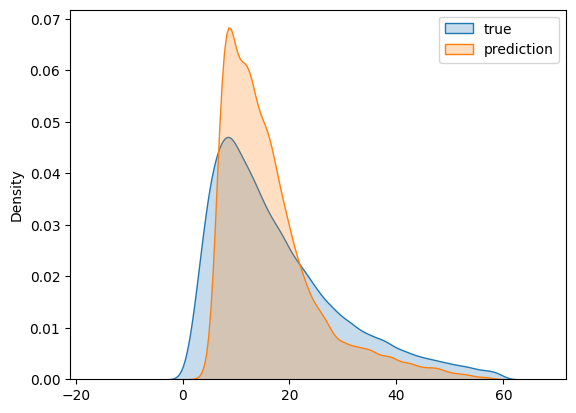

In [41]:
sns.kdeplot(y_val_ridge, label='true', fill=True)
sns.kdeplot(y_pred_ridge, label='prediction', fill=True)

plt.legend()

plt.show()

In [101]:
path = 'models'
model_name = 'ridge'

save_model(path=path, model_name=model_name, dv=dv, model=ridge)

# MLFLOW

In [47]:
X_train, X_val = vectorizer(
    categorical=categorical, numerical=numerical, df_train=df_train, df_val=df_val)

y_train = df_train[target].values
y_val = df_val[target].values

with mlflow.start_run():

    # etiqueta para agregar mas informacion al experimento
    mlflow.set_tag('describe', 'testing mlflow')

    mlflow.log_param('train-data-path', 'green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', 'green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param('alpha', alpha)

    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred_lasso)
    mlflow.log_metric('rmse', rmse)